In [1]:
import sys
import os
import torch
import torch.nn as nn
import tiktoken

In [2]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [ ]:
from utils.gpt_download import download_and_load_gpt2
from utils.gpt import GPTModel
from utils.load_and_save import load_weights_into_gpt

from utils.generator import generate
from utils.conversion import text_to_token_ids, token_ids_to_text

## Loading the pre-trained weights

Instead of using the smallest $124$-million-parameter model as before, we load the medium-sized model with $355$ million parameters. The reason for this choice is that the 124-million-parameter model is too limited in capacity to achieve.

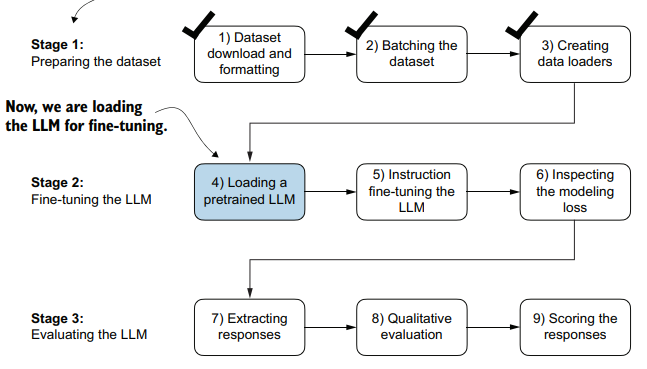

In [ ]:
BASE_CONFIG = {
 "vocab_size": 50257, # Vocabulary size
 "context_length": 1024, # Context length
 "drop_rate": 0.0, # Dropout rate
 "qkv_bias": True # Query-key-value bias
}
model_configs = {
 "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
 "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
 "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
 "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}



CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings, params = download_and_load_gpt2(
    model_size=model_size, 
    models_dir="gpt2"
)


In [ ]:
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

### Load the instruction data

In [ ]:
import json

In [ ]:
cwd_path = os.getcwd()


parent_path = os.path.join(cwd_path, '..')


relative_file_path = os.path.join(parent_path, 'data', 'instruction-data.json') # This is still a relative path with .. in it.


file_path = os.path.abspath(relative_file_path) 

with open(file_path, "r") as file:
    data = json.load(file)


train_portion = int(len(data) * 0.85) 
test_portion = int(len(data) * 0.1) 
val_portion = len(data) - train_portion - test_portion 

train_data = data[: train_portion]
test_data = data[train_portion: train_portion + test_portion]
val_data = data[train_portion + test_portion: ]

#### Evaluate performance off pre-trained LLM on instruction data

In [12]:
from utils.instruction_dataset import format_input

In [ ]:
torch.manual_seed(123)
input_text = format_input(val_data[5])
print(input_text)



In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

In [ ]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [ ]:
print("Generated text:\n", generated_text)
response_text = generated_text[len(input_text):].strip()
print("------------------------------------------------------------------")
print("Response part:\n", response_text)
print(response_text)

This output shows that the pretrained model is not yet capable of correctly following
the given instruction. 

While it does create a Response section, it simply repeats the original input sentence and part of the instruction, failing to perform the task requested.

## Fine-tuning 
For the fine-tuning process itself, we can reuse the loss calculation and training functions implemented in chapter 5.


In [ ]:
from utils.loss import calc_loss_loader
from utils.train import train_model_simple

from utils.instruction_dataset import InstructionDataset, custom_collate_fn, create_dataloader

In [ ]:
from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

#### Preparing the dataloader


In [ ]:
train_dataset = InstructionDataset(train_data, tokenizer)

train_loader = create_dataloader(train_dataset, batch_size =8, custom_collate_func=customized_collate_fn)

val_dataset = InstructionDataset(val_data, tokenizer)

val_loader = create_dataloader(val_dataset, batch_size =8, custom_collate_func=customized_collate_fn)

test_dataset = InstructionDataset(test_data, tokenizer)

test_loader = create_dataloader(test_dataset, batch_size =8, custom_collate_func=customized_collate_fn)

In [ ]:
print("Train loader:")

inputs, targets = next(iter(train_loader))

print(inputs.shape, targets.shape)

inputs, targets = next(iter(train_loader))
print(inputs.shape, targets.shape)

### Calculating initial loss for training and validation sets

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

with torch.no_grad():
    train_loss = calc_loss_loader(
    train_loader, model, device, num_batches=5
 )
    val_loss = calc_loss_loader(
    val_loader, model, device, num_batches=5
)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)


### Fine-tuning using the train loop

starting context to evaluate generated LLM responses during training based on the first
validation set instruction (`val_data[0]`)

In [ ]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(
    model.parameters(), lr=0.00005, weight_decay=0.1
)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

In [ ]:
print(next(model.parameters()).device)

In [ ]:
input_text = format_input(test_data[0])
print(input_text)
print("------------------------------------------------------------------")

moved_idx = text_to_token_ids(input_text, tokenizer).to(device)
token_ids = generate(
    model=model,
    idx=moved_idx,
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)
response_text = generated_text[len(input_text):].strip()
print("Response generated by model:\n", response_text)

In [ ]:
generated_text

### Saving the fine-tuned LLM

In [ ]:
from utils.load_and_save import save_model

model_save_name = f"gpt2-{model_size}-finetuned.pth"
save_model(model, model_save_name, optimizer = None, save_dir_name = 'models')

In [ ]:
from utils.plot import plot_losses

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

The rapid decrease in losses during the initial phase indicates that the model quickly learns meaningful patterns and representations from the data. Then, as training progresses to the second epoch, the losses continue to decrease but at a slower rate, suggesting that the model is fine-tuning its learned representations and converging to a stable solution.


In [ ]:
test_data[:3]

## Evaluating the LLM

First, we extract the model-generated responses for each input in the test dataset and collect them for manual analysis, and then we evaluate the LLM to quantify the quality of the responses.

But before that, we start simple and print the model responses alongside the expected test set answers for the first three test set entries, presenting them side by side for comparison.

In [ ]:
torch.manual_seed(123)

for entry in test_data[:3]: 
    input_text = format_input(entry)
    token_ids = generate( 
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )

    generated_text = token_ids_to_text(token_ids, tokenizer)
    
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

In [ ]:
test_data[0]

In [ ]:
own_data = {
    'instruction': 'Answer humanly.',
    'input': "What's up bro?",
    'output': "Not much, just chilling. How about you?"
}

In [ ]:
input_text = format_input(own_data)
# print(input_text)
print("------------------------------------------------------------------")

moved_idx = text_to_token_ids(input_text, tokenizer).to(device)
token_ids = generate(
    model=model,
    idx=moved_idx,
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)

generated_text = token_ids_to_text(token_ids, tokenizer)
    
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(input_text)
print(f"\nCorrect response:\n>> {own_data['output']}")
print(f"\nModel response:\n>> {response_text.strip()}")
print("-------------------------------------")

### But, how do we evaluate LLM?

A model generating a response "The chef prepared delicious pizza." while the correct response was "The chef cooked delicious pizza."

How do we quanitify and give a score?

Instruction-fine-tuned LLMs such as chatbots are evaluated via multiple approaches:

1. Short-answer and multiple-choice benchmarks, such as **Measuring Massive Multitask Language Understanding** (MMLU; https://arxiv.org/abs/2009.03300),
which **test the general knowledge** of a model.

2. Human preference comparison to other LLMs, such as LMSYS chatbot arena
(https://arena.lmsys.org).

3. Automated conversational benchmarks, where another LLM like GPT-4 is
used to evaluate the responses, such as AlpacaEval (https://tatsu-lab.github.io/alpaca_eval/)


Since we are primarily interested in **assessing conversational performance** rather than just the ability to answer multiple-choice questions, **human evaluation** and **automated metrics** are more relevant.

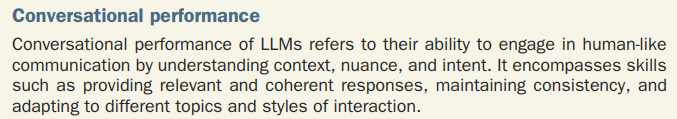

Considering the scale of the task at hand, we will implement an approach similar to automated conversational benchmarks, which involves evaluating the responses
automatically using another LLM. 

We will make our own custom test set for the another LLM by appending the generated
model responses to the `test_set` dictionary and save the updated data as an
`"instruction-data-with-response.json"`

In [ ]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)
    
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )

    generated_text = token_ids_to_text(token_ids, tokenizer)
    
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )
    
    test_data[i]["model_response"] = response_text

cwd_path = os.getcwd()


parent_path = os.path.join(cwd_path, '..')


relative_file_path = os.path.join(parent_path, 'data', 'instruction-data-with-response.json') # This is still a relative path with .. in it.


file_path = os.path.abspath(relative_file_path)

if not os.path.exists(file_path): 
    with open(file_path, "w") as file:
        json.dump(test_data, file, indent=4) 


In [ ]:
print(test_data[0])

To evaluate test set responses in an automated fashion, we utilize an existing instruction-fine-tuned 8-billion-parameter Llama 3 model developed by Meta AI.

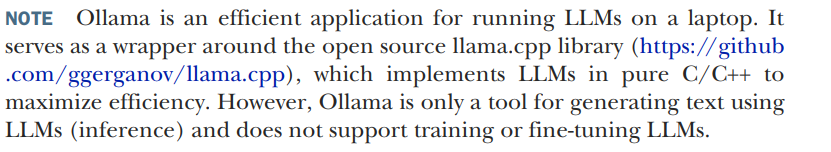

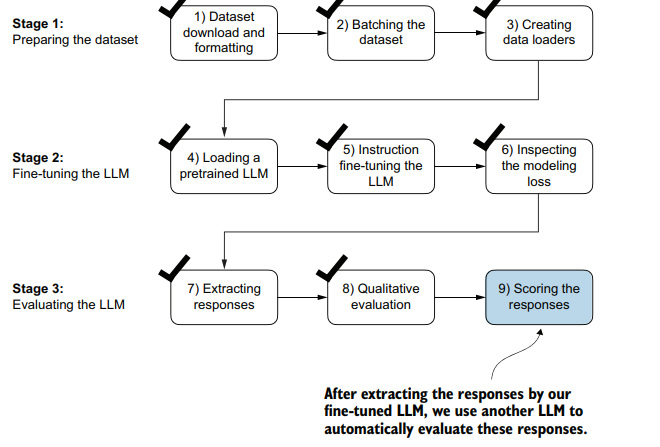

In [3]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError(
        "Ollama not running. Launch ollama before proceeding."
    )
    
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


The query_model function shown in the following listing demonstrates how to use the REST API for interacting with ollama.

In [6]:
import urllib.request
import json

def query_model(prompt, model="llama3", url="http://localhost:11434/api/chat"):

    data = { 
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": { 
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }
    payload = json.dumps(data).encode("utf-8") 

    request = urllib.request.Request( 
            url, 
            data=payload, 
            method="POST" 
        )
    
    request.add_header("Content-Type", "application/json")

    response_data = ""
    with urllib.request.urlopen(request) as response: 
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data


In [7]:
model = "llama3"
result = query_model("What do Llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. These grains provide essential nutrients and energy.
4. Fruits and vegetables: Llamas might enjoy fruits and veggies as treats or supplements, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas require access to mineral-rich substances, like salt licks or loose minerals, to ensure they're getting the necessary nutrients.

In their natural habitat, llamas might also eat:

* Leaves from trees and shrubs
* Bark (in some cases)
* Mosses and lichens

It's essential to provide a balance

First, we apply this approach to the first three examples from the test set that we
previously examined:

In [8]:
# Reloading the test_data 
# Not required if you are running the code in a single run.
cwd_path = os.getcwd()


parent_path = os.path.join(cwd_path, '..')


relative_file_path = os.path.join(parent_path, 'data', 'instruction-data-with-response.json') # This is still a relative path with .. in it.


file_path = os.path.abspath(relative_file_path)

with open(file_path, "r") as file:
    test_data = json.load(file)

In [10]:
test_data[0]

{'instruction': 'Rewrite the sentence using a simile.',
 'input': 'The car is very fast.',
 'output': 'The car is as fast as lightning.',
 'model_response': 'The car is as fast as a cheetah.'}

In [13]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.

Score:
>> I'd score this response an 80.

Here's why:

* The model has correctly identified that the input sentence needs to be rewritten using a simile (a comparison between two unlike things using "like" or "as").
* The model has chosen a suitable comparison, using a cheetah as the basis for the fast car. Cheetahs are known for their speed, making them a good fit for this analogy.
* However, while the response is generally good, it's not perfect. A score of 80 reflects that the model could have done slightly better.

To get to a perfect score (100), the model might consider using an even more vivid or unexpected comparison, such as "The car is as fast as a speeding bullet" or "The car is as fast as a runaway train". These comparisons are more surprising and engaging than simply comparing the car's speed to that of a cheetah.

-------------------------

Dataset response:
>> The

The generated responses show that the Llama 3 model provides reasonable evaluations and is capable of assigning partial points when a model’s answer is not entirely correct. 

For instance, if we consider the evaluation of the “cumulus cloud” answer, the model acknowledges the partial correctness of the response.

We can modify the prompt to just generate integer scores ranging from $0 to 100$, where 100 represents the best possible score. 

This modification allows us to calculate an average score for our model, which serves as a more concise and quantitative assessment of its performance.

In [17]:
# Not needed if you are running the code in a single run.
import tqdm

In [20]:
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []

    for entry in tqdm.tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only." 
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        
        except ValueError:
            print(f"Could not convert score: {score}")
            continue
    
    return scores

In [21]:
scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries: 100%|██████████| 110/110 [00:09<00:00, 11.91it/s]

Number of scores: 110 of 110
Average score: 46.93



To further improve our model’s performance, we can explore various strategies,
such as:

1. Adjusting the hyperparameters during fine-tuning, such as the learning rate,
batch size, or number of epochs

2. Increasing the size of the training dataset or diversifying the examples to cover
a broader range of topics and styles

3. Experimenting with different prompts or instruction formats to guide the
model’s responses more effectively

4. Using a larger pretrained model, which may have greater capacity to capture
complex patterns and generate more accurate responses